# Vehicle Detection and Tracking

In this project I will built a pipeline which detects and tracks vehicles in a video. 

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

The way this is organized is I do each of the above steps separately with an example or to, and then combine the whole thing into a pipeline at the end. 

## Import Libraries

Import nesseary libraries and lesson_code from udacity.

In [14]:
#================================================
#
# Import libraries from lessons
#
#=================================================

import numpy as np
import cv2
import matplotlib; matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from skimage.feature import hog
from skimage import color, exposure

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from scipy.ndimage.measurements import label

import time
import pickle
 
from sklearn.model_selection import train_test_split


#!!!! figure this out if need be
# import udacity lesson functions
#from lesson_functions import *

# for plotting out to console
%matplotlib inline

/home/andrewrs/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Loading Data 

Some examples were provided to test the functions on in the project folder. I loaded up the images from the test images folder. Also, I loaded in the data for training the classifier here.

In [68]:
#=========================================================
#
# Load in the test images. 
#
#=========================================================

# Make a list of test images
images = glob.glob('test_images/test*.jpg')

# put them into a way to 
test_img_list = []
for fname in images:
    img = mpimg.imread(fname)
    # if needed 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img_list.append(img)

In [16]:
#=========================================================
#
# Load in the training data
#
# from class material with edits
#
# Data sources:
# small data set: https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip 
#                 https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip 
# bigger data set: https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
#                  https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
#=========================================================

# make a list of car and not car images from the small data set
images = glob.glob('data/*/*/*/*')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
#====================================================
# test the length of each, double check by looking
n_len = len(notcars)
c_len = len(cars)

mess = 'Number of non car images: ' + str(n_len) + '\n' + 'Number of car images: ' + str(c_len)

print(mess)

Number of non car images: 1125
Number of car images: 1196


In [37]:
#==========================================================
# this one is for using the bigger data set

# make a list of car and not car images from the big data set
# comment out if small data set wanted
# here, I had to change the folder names a bit because the naming scheme 
#   was different than the smaller dataset
images = glob.glob('bigger_data/*/*/*/*')
cars = []
notcars = []

for image in images:
    if 'extras' in image:
        notcars.append(image)
    else:
        cars.append(image)

#====================================================
# test the length of each, double check by looking
n_len = len(notcars)
c_len = len(cars)

mess = 'Number of non car images: ' + str(n_len) + '\n' + 'Number of car images: ' + str(c_len)

print(mess)

Number of non car images: 8968
Number of car images: 8792


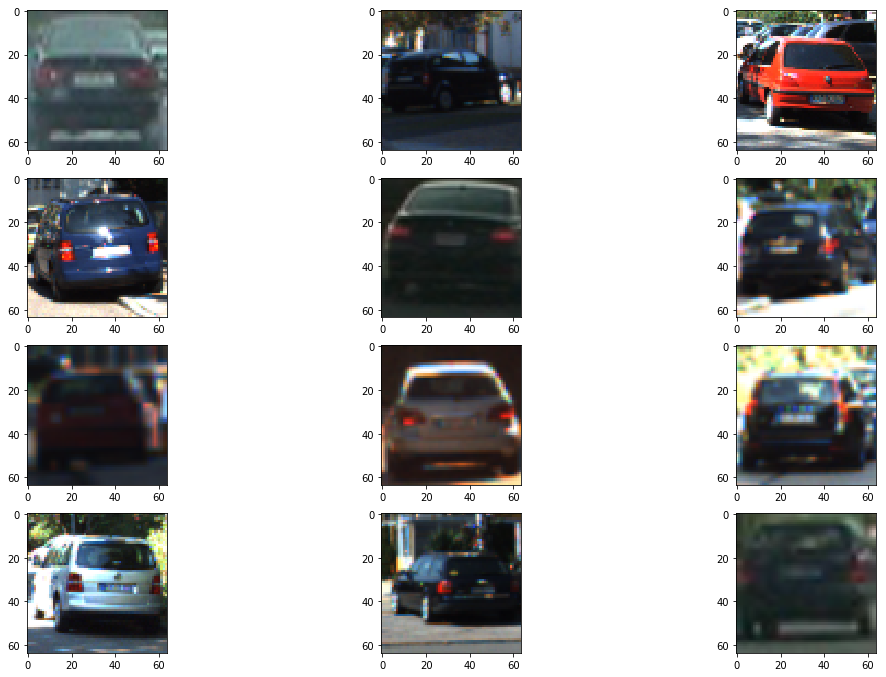

In [39]:
#====================================================
# double check the has car
# Generate a random index to look at a car image
number = 12
ind = np.random.randint(0, len(cars), size = number)

img_list = []
for i in ind:
    image = mpimg.imread(cars[i])
    img_list.append(image)
#================================================
# plot tests
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)

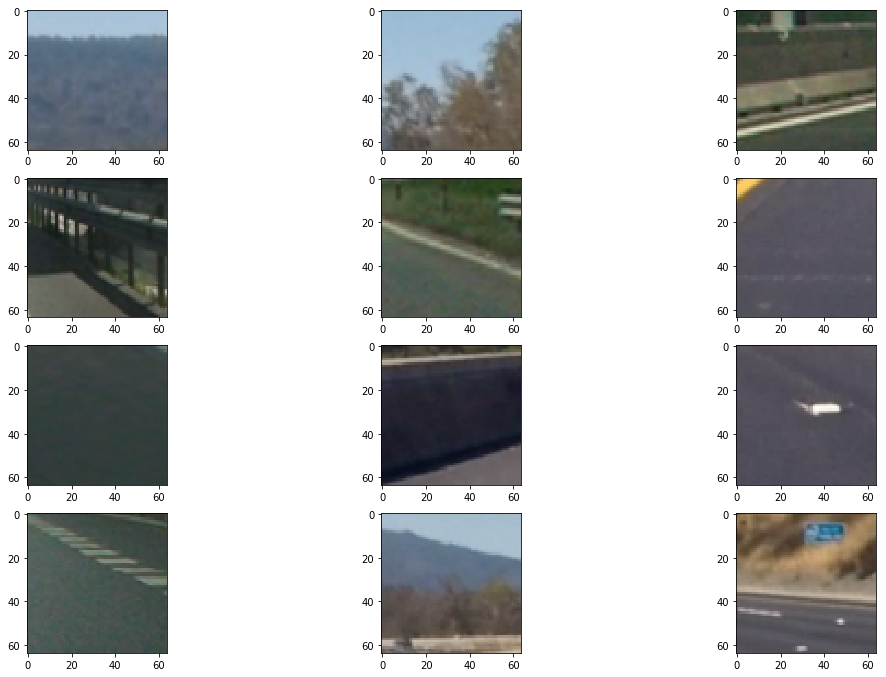

In [40]:
#====================================================
# double check the DOES NOT have car
# Generate a random index to look at a car image
number = 12
ind = np.random.randint(0, len(notcars), size = number)

img_list = []
for i in ind:
    image = mpimg.imread(notcars[i])
    img_list.append(image)
#================================================
# plot tests
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)

## Histogram of Oriented Gradients (HOG) feature extraction

Here I extrated the HOG feature from images. A lot of this code is from the lessons. 

/home/andrewrs/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


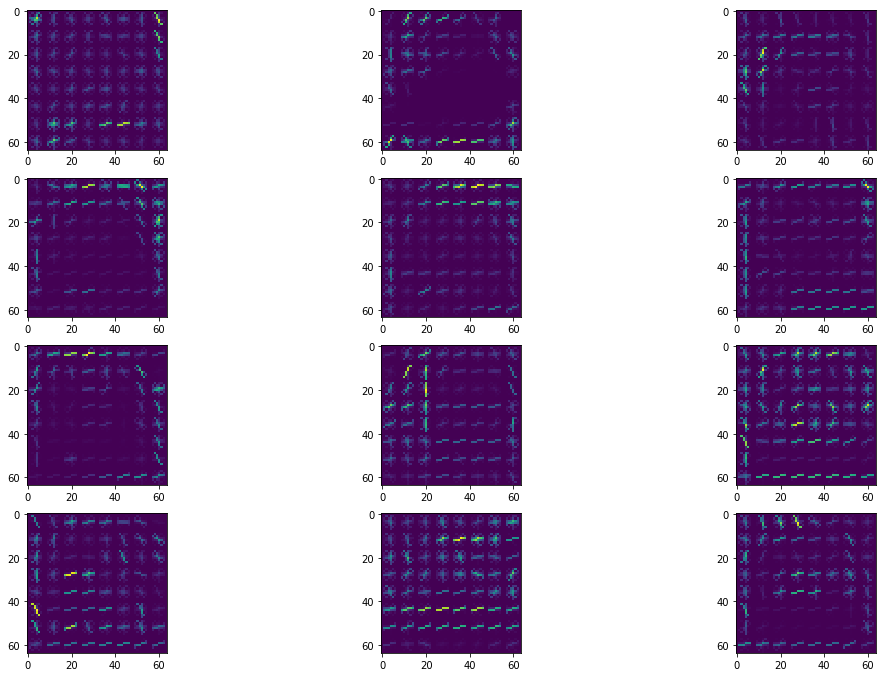

In [41]:
#================================================
#
# HOG feature extraction
#
# From class material with edtis
#
#=================================================

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#================================================
# grab a test example from the "cars" dataset, big or small
#   depending on what you loaded

# Generate a random index to look at a car image
number = 12
ind = np.random.randint(0, len(cars), size = number)
# Read in the image
#image = mpimg.imread(cars[ind])
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters, theyse stay constant
orient = 9
pix_per_cell = 8
cell_per_block = 2


#=======================================================
# test
# loop through number of images and plot them all out
img_list = []
for i in ind:
    image = mpimg.imread(cars[i])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    feat, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    img_list.append(hog_image)


#================================================
# plot HOG images 
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)



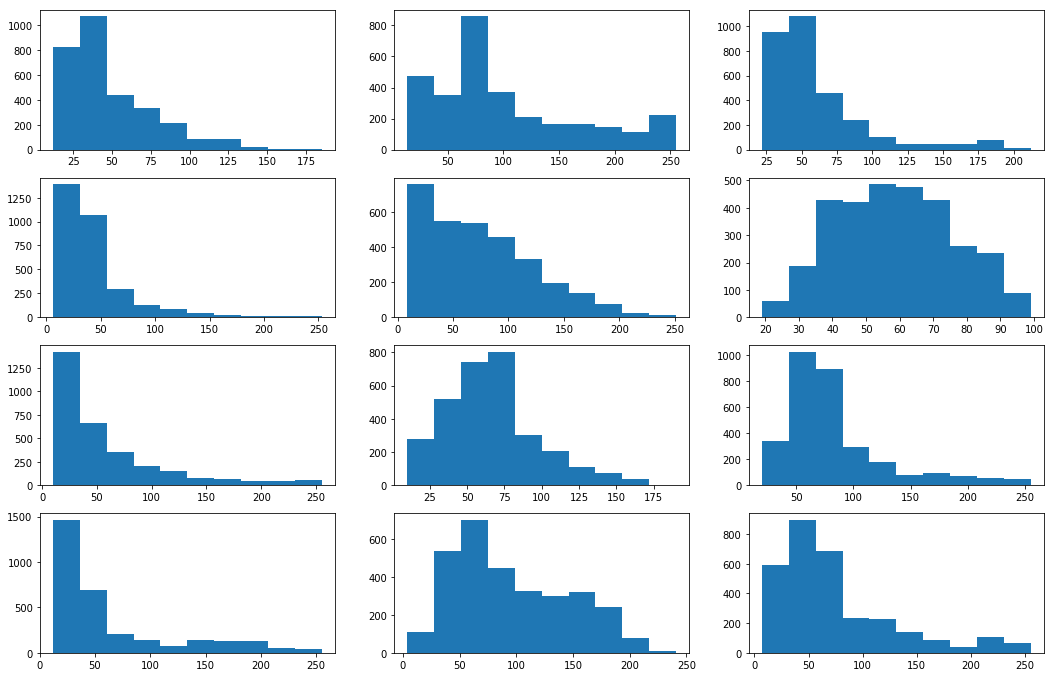

In [42]:
#=============================================================
#
# The bin spatial function
#
# From the class notes with edits
#
#===============================================================

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#==============================================================
# test 
# Generate a random index to look at a car image
number = 12
ind = np.random.randint(0, len(cars), size = number)
# Read in the image
#image = mpimg.imread(cars[ind])
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


#======================================================
# loop through number of images and plot them all out
img_list = []
for i in ind:
    image = cv2.imread(cars[i])
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    bin_feat = bin_spatial(image, size=(32, 32))
    #hist = np.histogram(bin_feat)
    img_list.append(bin_feat)


#================================================
# plot HOG images 
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.hist(img_loop)

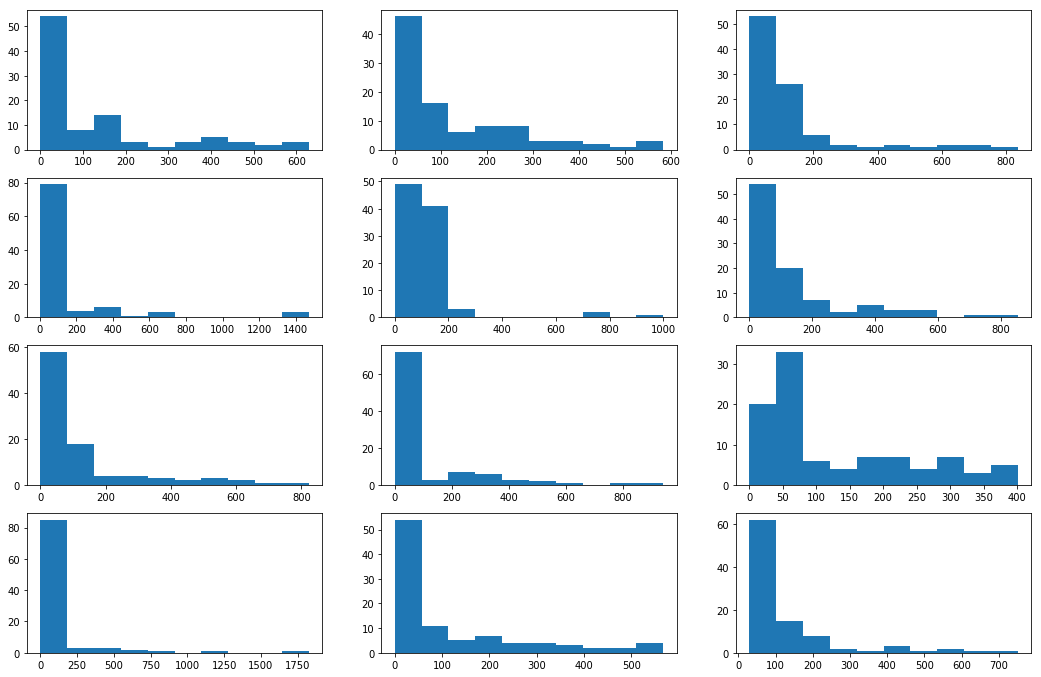

In [43]:
#=============================================================
#
# The color histogram function
#
# From the class notes with edits
#
#===============================================================

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#==============================================================
# test 
# Generate a random index to look at a car image
number = 12
ind = np.random.randint(0, len(cars), size = number)
# Read in the image
#image = mpimg.imread(cars[ind])
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


#======================================================
# loop through number of images and plot them all out
img_list = []
for i in ind:
    image = cv2.imread(cars[i])
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    color_feat = color_hist(image, nbins=32, bins_range=(0, 256))
    #hist = np.histogram(bin_feat)
    img_list.append(color_feat)


#================================================
# plot 
%matplotlib inline
# plot seected examples from original and rotated sets#
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.hist(img_loop)


/home/andrewrs/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


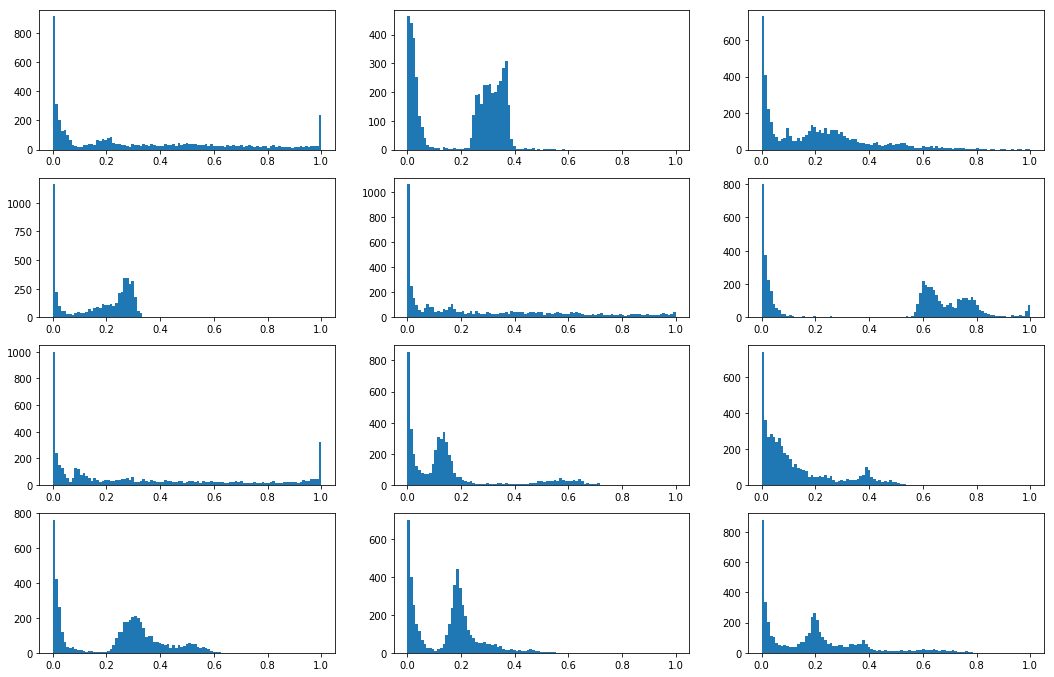

In [44]:
#=============================================================
#
# The extract features function
#
# From the class notes with edits
# I added the hog features 
#===============================================================


# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        # add the hog features with the parameters already defined
        hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


#======================================================
# test return features
# Generate a random index to look at a car image
number = 6
ind = np.random.randint(0, len(cars), size = number)
ind2 = np.random.randint(0, len(notcars), size = number)

# Read in the image
#image = mpimg.imread(cars[ind])
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


#======================================================
# loop through number of images and plot them all out
img_list = []
for i in range(0, number):
    image = cars[ind[i]]
    image2 = notcars[ind2[i]]
    img_list.append(image)
    img_list.append(image2)

# run the feature extraction
feat = extract_features(img_list, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))



#================================================
# plot 
%matplotlib inline
# plot seected examples from original and rotated sets#
plt.figure(figsize=(18, 18))
for i, img_loop in  enumerate(feat):
    plt.subplot(6,3,1+i)
    plt.hist(img_loop, bins = np.linspace(0, 1, 100))


## Implement a sliding-window technique

Now, the trained classifier has to be implemented through a sliding window technique. The sliding window technique will select various "boxes" or subsets of an imput image which will be transformed into inputs for the classifier. This way, the classifier can be applied over and over to all areas of an input image. 

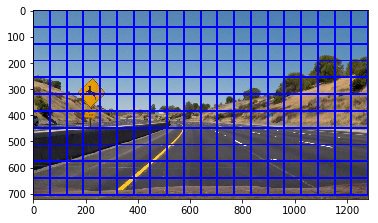

In [23]:
#=================================================
#
# Sliding Window Techinique
#
# from class material with edits
#
#=================================================

image = test_img_list[0]

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    x_start_stop= list(x_start_stop)
    y_start_stop = list(y_start_stop)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(image, x_start_stop=(None, None), y_start_stop=(None, None), xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)




In [45]:
#=================================================
#
# Extracting Features from the sliding window
#
# from class material with edits
#
#=================================================

# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Also, re-define the extract_features function to a mor robust version 
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



## Test out the Classifier and window search 

Here I'm testing out the classifier on selected full images. I'm going to re-train another classifier, with the parameters upfront to fine tune a better model than before. After that, I'll try it on a few test images to see how it does.  

The training hyper parameters, and the parameters used in the window search are extrememly important to getting a good result. This part took a little trial and error. The SVM does train pretty quickly, and I think I could really improve the results with better data preperation, as I'm not sure my model generalizes great.

In [100]:
#========================================================
#
# Testing out the classifer and window search 
#
# from class material with edits 
#
#=======================================================


# cars and notcars is already defined from the first SVM I trained. 

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# extract the features 
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# extract the features 
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


# get the car labeled features
#car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# get the not car labeled features. 
#notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# print out info
print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))



Using: 16 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 12960


In [127]:
#==========================================
#
# Train the linear SVC 
#
# From class notes with edits 
# also: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
#=========================================
# added l1 penalty. Although this can create sparse weight, it performed 
#  better than without and with l2. 
svc = LinearSVC(#class_weight=None, 
                #dual=False, 
                #fit_intercept=True,
                #intercept_scaling=1, 
                #loss='squared_hinge', # squared_hinge
                #max_iter=2000,
                #multi_class='ovr', 
                #penalty='l2', 
                #random_state = rand_state, 
                #tol=0.0001,
                #verbose=1
                )
# Check the training time for the SVC
t=time.time()

# adding a penalty term to the svc
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


45.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9645


In [69]:
len(test_img_list)

6

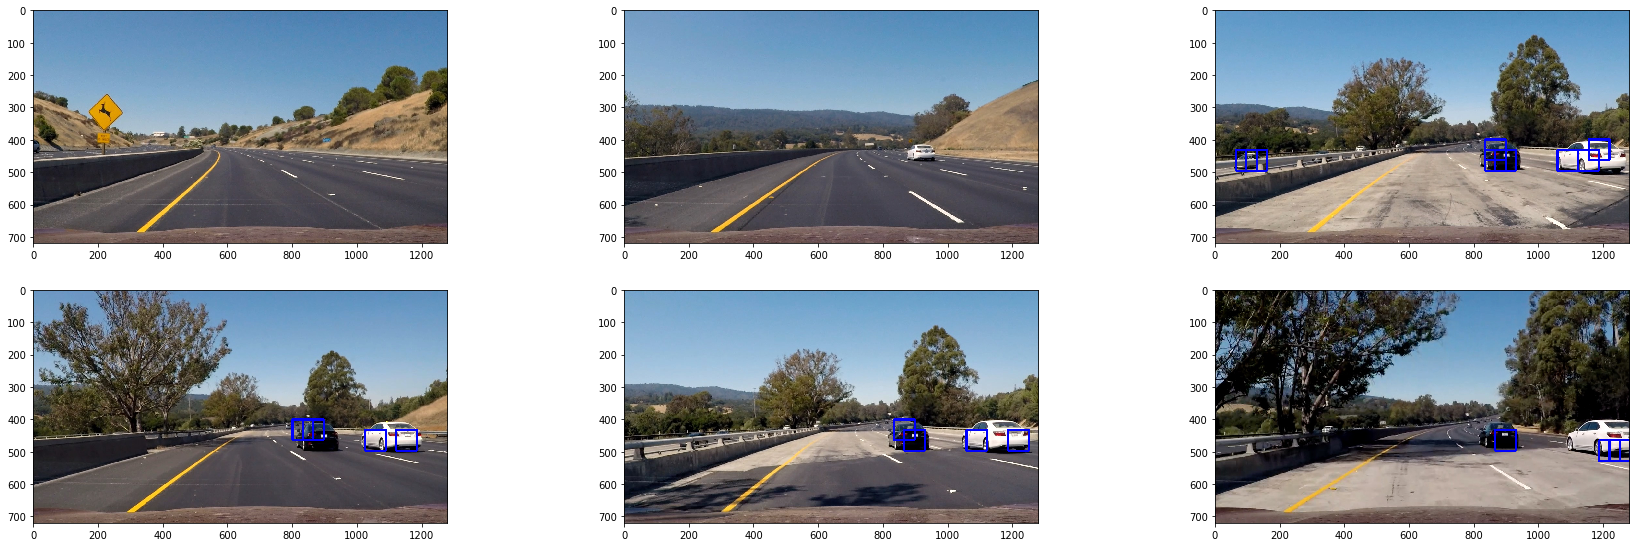

In [102]:
#============================================================
#
# Test the trained classifier and sliding window techinique 
#  on one of the test images. 
#
# 
#==========================================================

#image = test_img_list[0]
#draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#image = image.astype(np.float32)/255

#img_list = test_img_list
# stop the classifer from shooting into the the trees
img_list = []
y_start_stop = [400, 650] # Min and max in y to search in slide_window()

for image in test_img_list:
    # correct the image for jpg type
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    img_list.append(window_img)
    
# plot 
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(30, 30))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)


## Further Sliding Window Techniques to Improve Performance

The classifier is ok, but still needs some work before implementing on a movie. Here I'll continue to use sliding window techniques to improve the result.

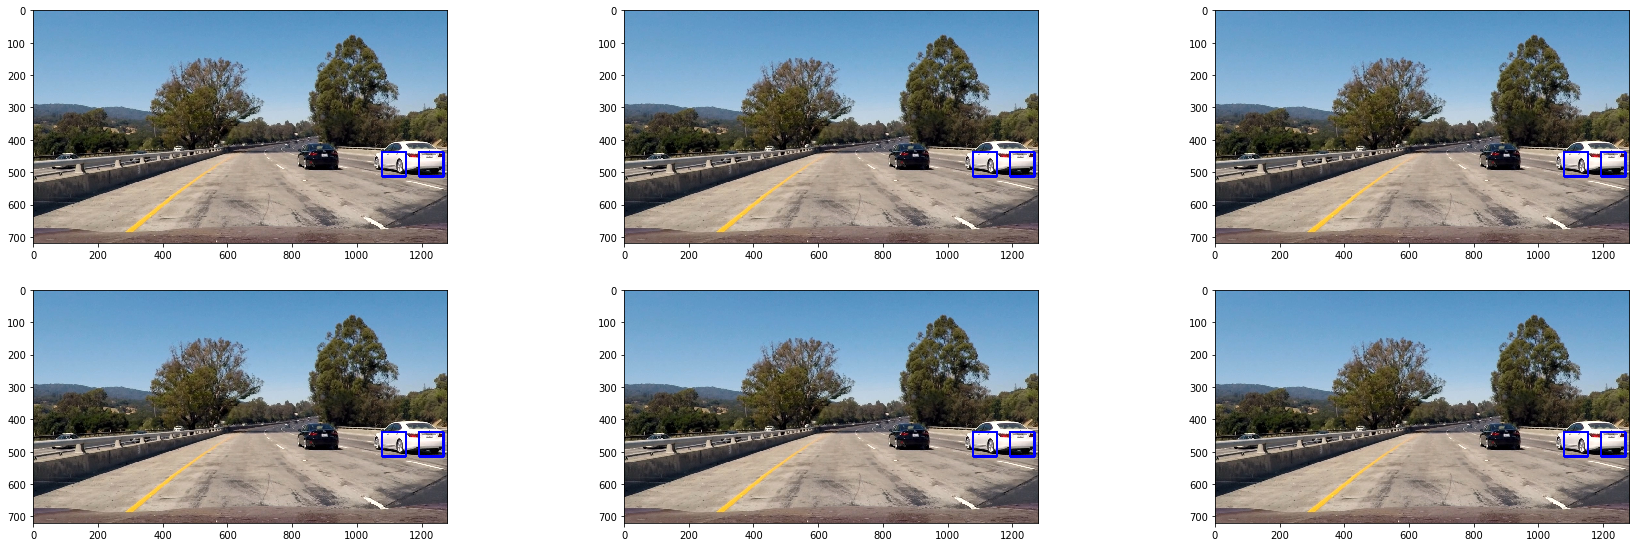

In [124]:
#===============================================
# The Find Cars function 
#
# From class nots with edits
# also inspired by: https://github.com/NikolasEnt/Vehicle-Detection-and-Tracking/blob/master/VehicheDetect.ipynb
#===============================================


# the find cars function from class with the 2 and 3 hog features commented 
#  out. No sure why I had to do this, but it works. 
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, vis = False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # init save box list if in pipeline 
    if vis == False:
        save_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # ugly but works 
                one = xbox_left
                two = ytop_draw+ystart
                three = xbox_left+win_draw
                four = ytop_draw+win_draw+ystart
                
                # check if vis is true of not
                if vis == False:
                    next_box = (one, two), (three, four)
                    save_boxes.append(next_box)
                else:
                    cv2.rectangle(draw_img,(one, two),(three, four),(0,0,255),6) 
        if vis == False:
            kickout = save_boxes
        else: 
            kickout = draw_img
    
    return kickout

#=================================================
# convert color function
# i made this like a peice of the origial extract features function 
#  so you could change the color space. 
def convert_color(image, cspace = 'RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: image = np.copy(image)  
    
    return image


# new params 
ystart = 400
ystop = 650
scale = 1.2

# old params 
#color_space = 'LUV'  #Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 16  # HOG orientations
#pix_per_cell = 16 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
#spatial_size = (64, 64) # Spatial binning dimensions
#hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


#=================================================================
# test the find cars function
test_img = mpimg.imread('test_images/test1.jpg')

out_img = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space = color_space)

# plot all the images
img_list = []
for timg in test_img_list:
    test_img_b = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space = color_space, vis = True)
    img_list.append(test_img_b)

# plot 
%matplotlib inline
# plot seected examples from original and rotated sets
plt.figure(figsize=(30, 30))
for i, img_loop in  enumerate(img_list):
    plt.subplot(6,3,1+i)
    plt.imshow(img_loop)

plt.imshow(test_img_b)

## Dealing with False Positives and Multiple Detections

There are still a whole lot of false positives. The class material provides a number of functions to deal with false positives through heatmap filtering. 

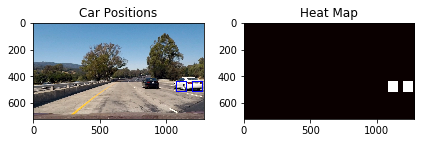

In [126]:
box_list = out_img

# Read in image similar to one shown above 
image = test_img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Building the pipeline and testing

The left image output above is the one I'm after for the video. Here is the pipeline built with the functions above and made to output a tracking image based on one input image. 

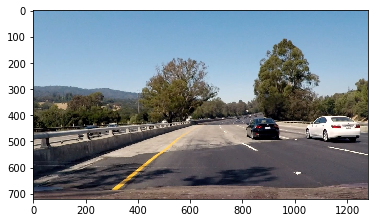

In [115]:
#=======================================================
#
# Pipeline for processing video images
#
# from the class material with edits. 
#
#
#=======================================================

# here's the pipeline. It has a number of hard coded arguments in here, so,
#  it could use some work but it still outputs the video
def pipeline(img):
    # empty init
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # uses the default vis value of false
    output_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space = color_space)
    
    # Add heat to each box in box list
    heat = add_heat(heat, output_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

#==================================================================
# test 
test_im = test_img_list[4]

test_out = pipeline(test_im)

plt.imshow(test_out)
    

## Run the pipeline on a video 

Next I'll use the pipeline to create a video. Much like the previous project, I'm using moviepy.editor to loop the frames and create a new video. 

In [99]:
#=================================================
#
# Run the pipline on a video 
#
# inspired by: https://github.com/NikolasEnt/Vehicle-Detection-and-Tracking/blob/master/VehicheDetect.ipynb
#              http://zulko.github.io/moviepy/
#  and my repo from the last project: https://github.com/andrewsommerlot/Carnd-Advanced-Lane-Lines                 
#=================================================

from moviepy.editor import VideoFileClip


# loop the pipeline function over the video one frame at a time. 
original_video = VideoFileClip("test_video.mp4")
lane_video = original_video.fl_image(pipeline)

# writes out the video to 
lane_video.write_videofile('vehicle_tracking.mp4', audio=False)

[MoviePy] >>>> Building video vehicle_tracking.mp4
[MoviePy] Writing video vehicle_tracking.mp4


 97%|█████████▋| 38/39 [00:02<00:00, 18.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_tracking.mp4 

